# MDD

### Author: M.Ravasi

This notebook performs the standard Multi-dimensional convolution (MDC) and Multi-dimensional deconvolution (MDD) of 3D dataset using pylops-distributed

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from dask.distributed import Scheduler, Client

from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *

from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/MDD3D/"
nworkers = 4

Setup SSH cluster

In [3]:
client = Client('be-linrgsn223:8786')
client

Client Scheduler: tcp://be-linrgsn223:8786 Dashboard: http://be-linrgsn223:8787/status,Cluster Workers: 4 Cores: 48 Memory: 540.80 GB


In [4]:
nworkers_cluster = np.sum(np.array(list(client.ncores().values())))
nworkers_cluster

48

# Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ y(s,v,f) = \int_S R(s,v,f) x(r,v,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Load model ($m$) and kernel operator ($R$) 

In [9]:
###### Input parameters
par = {'ox':-300, 'dx':20,    'nx':31,
       'oy':-200, 'dy':20,    'ny':21,
       'ot':0,    'dt':0.004, 'nt':250,
       'f0': 20,  'nfmax': 200}

t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

m = da.from_zarr(os.environ["STORE_PATH"]+'/m.zarr')
m

mwav = da.from_zarr(os.environ["STORE_PATH"]+'/mwav.zarr')
mwav

dask.array<from-zarr, shape=(499, 651), dtype=float32, chunksize=(499, 651)>

In [10]:
K = da.from_zarr(os.environ["STORE_PATH"]+'/K.zarr')
K

dask.array<from-zarr, shape=(200, 651, 651), dtype=complex64, chunksize=(50, 651, 651)>

Define modelling operator

In [11]:
Kop = \
    pylops_distributed.waveeqprocessing.MDC(K, nt=2*par['nt']-1, 
                                            nv=1, dt=par['dt'], dr=par['dx']*par['dy'], 
                                            twosided=True)
ddottest(Kop, (2*par['nt']-1)*par['ny']*par['nx'], 
         (2*par['nt']-1)*par['ny']*par['nx'], 
         chunks=(Kop.shape[0], Kop.shape[1]),
         complexflag=3, verb=True);

Dot test passed, v^T(Opu)=-310939.020485 - u^T(Op^Tv)=-310939.020485


Create data using MDC

In [12]:
d = Kop * m.ravel()
d = d.reshape(2*par['nt']-1, par['ny']*par['nx'])
d

dask.array<reshape, shape=(499, 651), dtype=float32, chunksize=(499, 651)>

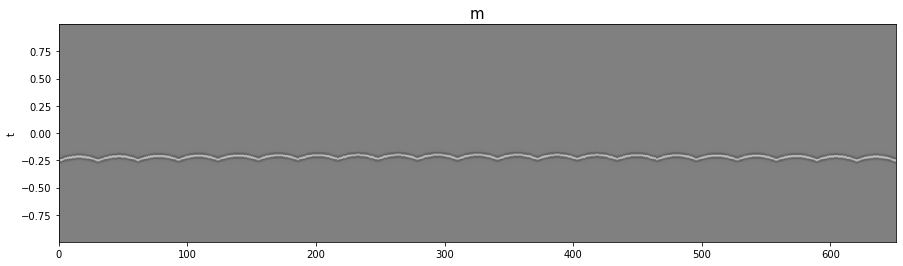

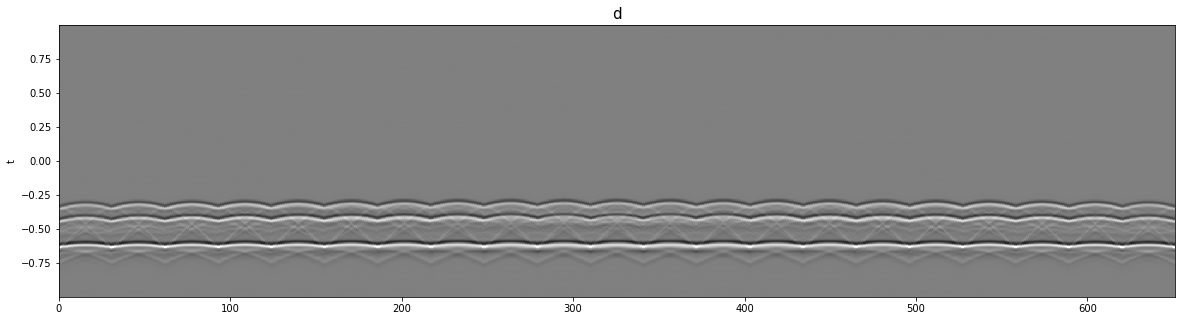

In [24]:
plt.figure(figsize=(15, 4))
plt.imshow(mwav, aspect='auto',
           interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(0, par['ny']*par['nx'], -t.max(), t.max()))
plt.title('m', fontsize=15)
plt.ylabel('t')

plt.figure(figsize=(20, 5))
plt.imshow(d, aspect='auto',
           interpolation='nearest', vmin=-2000, vmax=2000, cmap='gray',
           extent=(0, par['ny']*par['nx'], -t.max(), t.max()))
plt.title('d', fontsize=15)
plt.ylabel('t');

## Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

Compute adjoint and inverse

In [14]:
madj = Kop.H*d.flatten()
madj = madj.reshape(2*par['nt']-1, par['ny']*par['nx'])
madj = madj.compute()


In [15]:
madj = Kop.H*d.flatten()
madj = madj.reshape(2*par['nt']-1, par['ny']*par['nx'])
madj = madj.compute()

minv = dcgls(Kop, d.ravel(), niter=10, compute=False)
minv = minv.reshape(2*par['nt']-1, par['ny']*par['nx'])
minv = minv.compute()

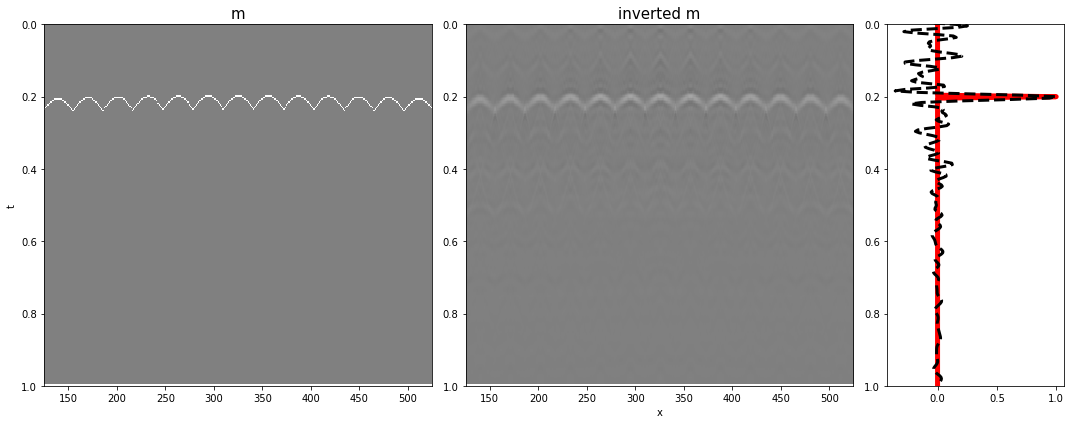

In [16]:
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(m, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-m.max(), vmax=m.max(),
           extent=(0, par['ny']*par['nx'],t2.max(),t2.min()))
ax1.set_title('m', fontsize=15)
ax1.set_ylabel('t')
ax1.set_xlim(par['ny']*par['nx']//2 - 200, par['ny']*par['nx']//2 + 200)
ax1.set_ylim(1., 0)

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-m.max(), vmax=m.max(),
           extent=(0, par['ny']*par['nx'],t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')
ax2.set_xlim(par['ny']*par['nx']//2 - 200, par['ny']*par['nx']//2 + 200)
ax2.set_ylim(1., 0)

ax3.plot(m[:, (par['ny']//2)*par['nx'] + par['nx']//2]/np.abs(m[:, (par['ny']//2)*par['nx'] + par['nx']//2]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, (par['ny']//2)*par['nx'] + par['nx']//2]/np.abs(minv[:, (par['ny']//2)*par['nx'] + par['nx']//2]).max(), t2, '--k', lw=3)
ax3.set_ylim(1., 0)
fig.tight_layout()

## Benchmark

In [17]:
dbench = Kop * m.ravel()
%timeit -n 10 -r 3 dbench.compute()

533 ms ± 7.41 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [18]:
madjbench = Kop.H * d.ravel()
%timeit -n 10 -r 3 (madjbench).compute()

1.03 s ± 7.52 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
